
This is an exercise on feature extractoin and Gaussian Processes interpolation of sparse time series.

## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in light emission in 6 different bands (i.e. wavelength ranges). The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023).

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good friend Gautham Narayan) to get started and ingest and preprocess the PLASTiCC challenge data. If you are not familiar with classes (object oriented syntax) do not worry about it: I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and fit the time series with Gaussian Processes.



In [53]:
import pandas as pd
import numpy as np
import pylab as pl
import io

%pylab inline
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import json
import os
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
import george
from george.kernels import ConstantKernel, ExpSquaredKernel, CosineKernel
from scipy.optimize import minimize


Populating the interactive namespace from numpy and matplotlib


# TASK I :  Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018

 The data on zenodo seems to be broken
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ

 You are only interested in the dataset called _plasticc_train_lightcurves.csv.gz_ and the correspondingn metadata _plasticc_train_metadata.csv.gz_ (note: metadata literally means data about the data)
 or if you get data from Kaggle (preferred) called
 _training_set.csv_ and _training_set_metadata.csv_

 The data is also in my drive at the link https://drive.google.com/file/d/1-M_xvSnZG0x26vsOPU4fS9HX3KQNu3y7/view?usp=sharing - from this name you can figure out how to read the data in with the package gdown.

**Preferred**: you can get the data from kaggle as (mind you, it will take some time! after downloading you want to _unzip_ the data)

`!kaggle competitions download -c PLAsTiCC-2018`

but you need to agree to the terms of competition first
https://www.kaggle.com/settings

In [54]:
!pip install kaggle

In [55]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [56]:
%mkdir -p /content/gdrive/MyDrive/MLTSA25/HW4
%cd /content/gdrive/MyDrive/MLTSA25/HW4


/content/gdrive/MyDrive/MLTSA25/HW4


In [57]:

envs = json.load(open("/content/gdrive/MyDrive/.kaggle/kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']


#Download Kaggle Datasets

In [58]:
!kaggle competitions download -c PLAsTiCC-2018

PLAsTiCC-2018.zip: Skipping, found more recently modified local copy (use --force to force download)


In [59]:
#!unzip PLAsTiCC-2018.zip training_set.csv training_set_metadata.csv


In [60]:
lcvs = pd.read_csv("training_set.csv")

In [61]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [62]:
print("The shape of light curves dataset is:", lcvs.shape)

The shape of light curves dataset is: (1421705, 6)


In [63]:
#check missing values
lcvs.isna().sum()

,0
object_id,0
mjd,0
passband,0
flux,0
flux_err,0
detected,0


Read the Kaggle challenge for a description of the data . This "Starter Kit" which includes a notebook (written by y good friend Gautham Narayan) may be especially useful
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit

For each object there are 6 time series in 6 different passbands: those are different wavelength ranges over which we observe light (e.g. r is roughtly the wavelengths corresponding to the red portion of the rainbow)

In [64]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [65]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [66]:
metadata = pd.read_csv("training_set_metadata.csv")
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [67]:
print("The metadata columns are: ", metadata.columns)

The metadata columns are:  Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target'],
      dtype='object')


In [68]:
print("The metadata dataset contains features: ", metadata.shape[1])

The metadata dataset contains features:  12


# TASK II : data exploration and visualization - plot some time series
Visualize my data to get a sense of what we are working with.


Plot light curves for 10 objects.


In [69]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [70]:
lcvs.loc[lcvs["object_id"] == 615]["passband"].unique()

array([2, 1, 3, 4, 5, 0])

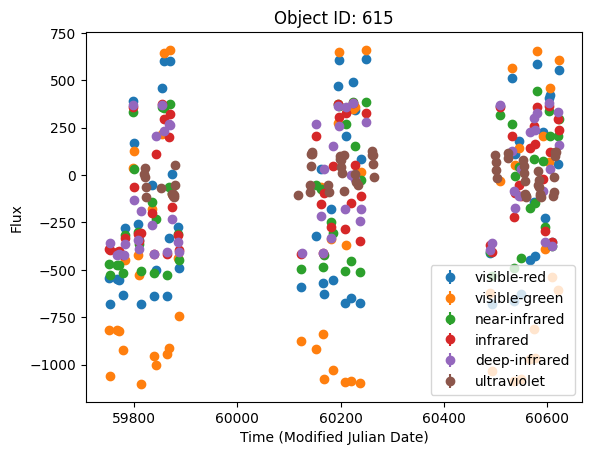

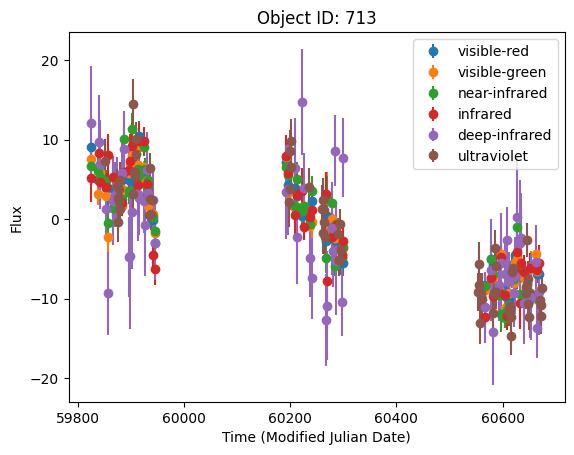

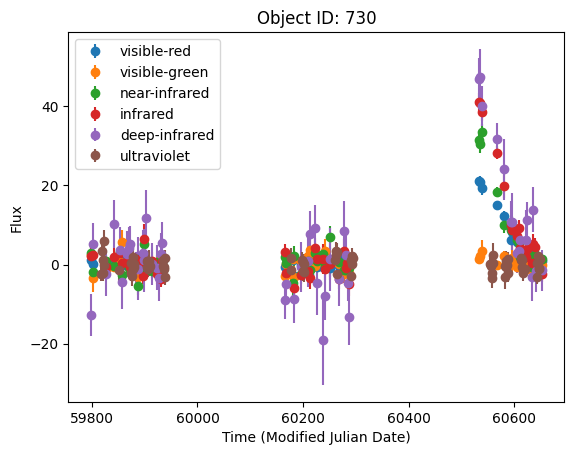

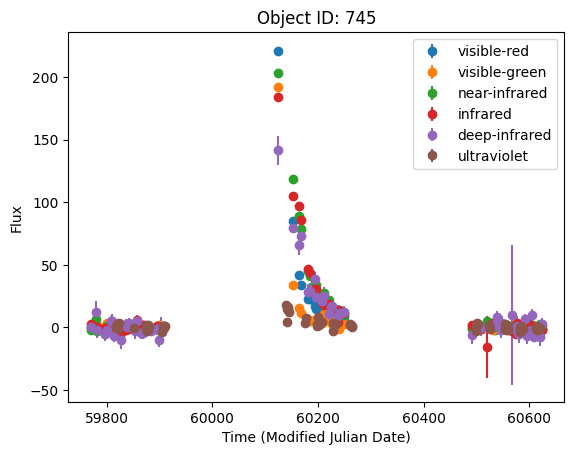

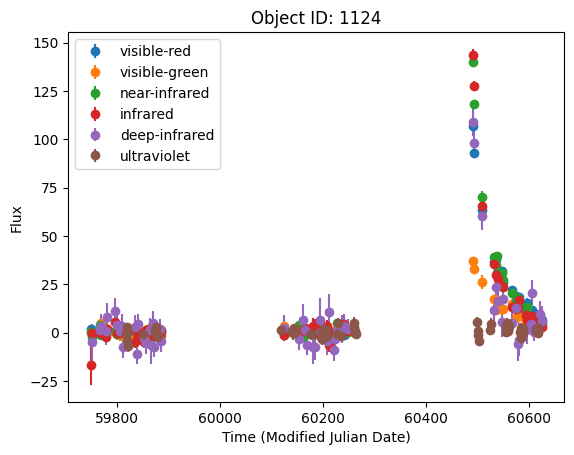

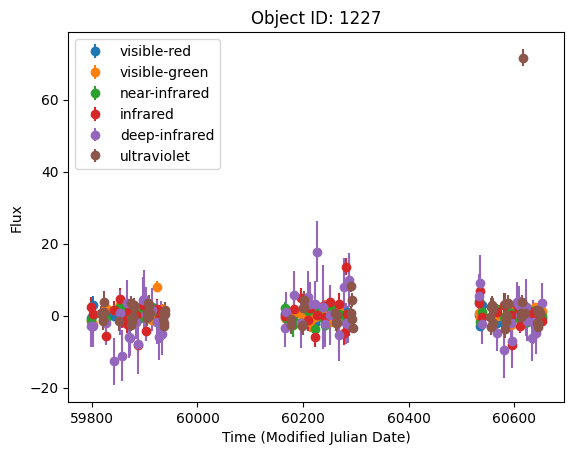

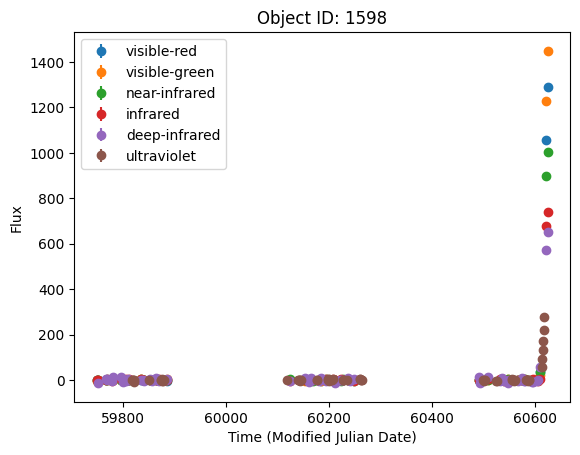

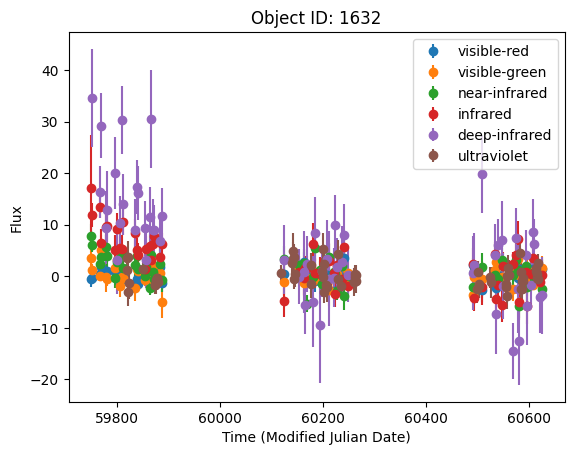

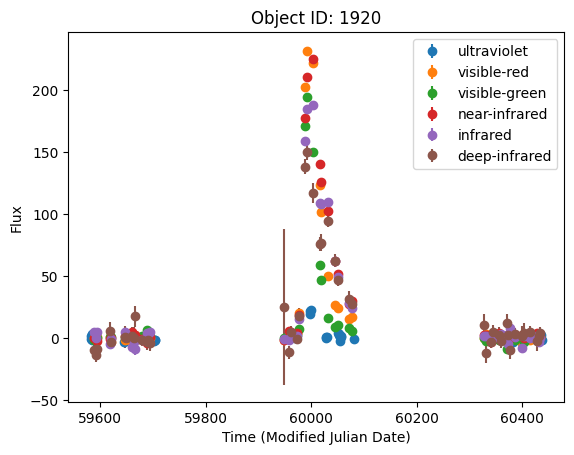

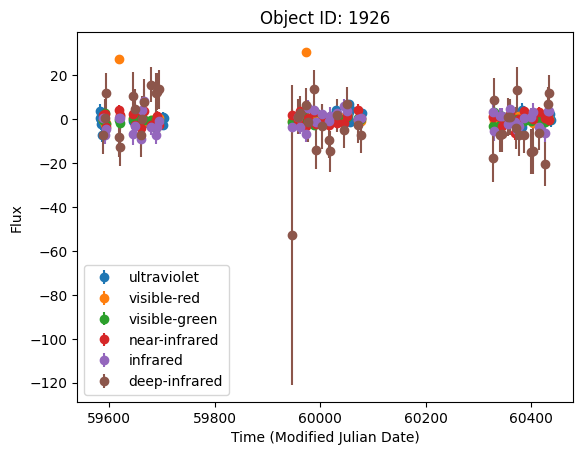

In [71]:
passband_names = {
+    0: 'ultraviolet',
+    1: 'visible-green',
+    2: 'visible-red',
+    3: 'near-infrared',
+    4: 'infrared',
+    5: 'deep-infrared'
 }


#Making a function to plot a lightcurve
def plot_lightcurve(id):

  pl.title("Object ID: {}".format(id))
  pl.xlabel("Time (Modified Julian Date)")
  pl.ylabel("Flux")
  object_data = lcvs.loc[lcvs["object_id"] == id]
  for band in object_data["passband"].unique():
     #selects only the data points belonging to the current passband
     passband_data = object_data.loc[object_data["passband"] == band]
     pl.errorbar(x=passband_data["mjd"],
                 y=passband_data["flux"],
                 yerr=passband_data["flux_err"],
                 fmt='o',
                 label=passband_names[band])

  pl.legend()
  pl.show()
  pl.close()




#create a figure container and an axis object inside of it
#ax = pl.figure(figsize=(10,10)).add_subplot(111)

for i in objects[0:10]:
  plot_lightcurve(i)



Figure 1 displays light curves for ten astronomical events from the dataset, with each event shown in its own panel.
The plotted points are color-coded to indicate the observational passband (wavelength range) used at each timestamp,
and vertical error bars reflect measurement uncertainties. A notable feature across all panels is the presence of two
distinct gaps in the data. These interruptions likely stem from the telescope’s observing schedule periodic pauses to
shift focus to other regions of the sky—which temporarily halts monitoring of these targets.

Plot explicitly object 84716

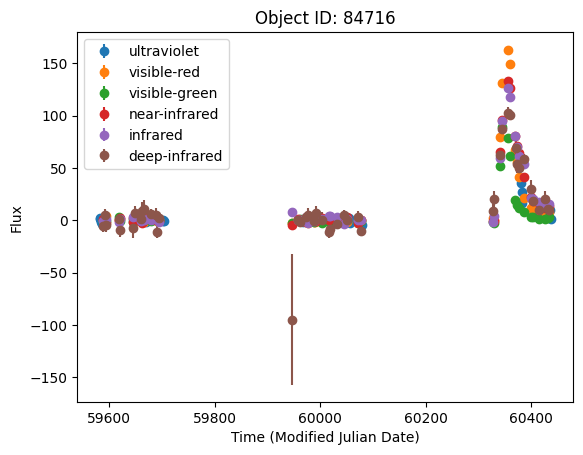

In [72]:
plot_lightcurve(84716)

Figure 2 presents the light curve of object 84716, revealing two key characteristics. For the majority of the
observational timeline, the source’s flux remains remarkably stable, showing minimal variation over time. However, a
pronounced brightening event occurs near the end of the monitoring period, marked by a sharp rise in flux at the latest
recorded timestamps

# TASK III: Extract features

Feature extraction refers to the extraction of statistical features of the datapoints or the generation of low dimensional representations of the data points that can then be passed to a classifier/regression

Extract at least 4 features including at least 1 feature from all three category below

The code that won the callenge did a number of smart things, of course. It was a feature based classification scheme, which included Gaussian Processes in the preprocessing. The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py

Examples of features you can extract:

- **from the original lightcurve**:
    - mean,
    - standard deviation,
    - skewness,
    - kurthosis,
    - minimum
    - maximmum,
    - error on the minimum and
    - error on the maximum,
- **from the standardized lightcurve**:
    - median
    - slope of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter


- **from the metadata file**:
    - decl; this is one of the positions in the sky variables: important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    
The feature in the metadata files are the hardest ones to decide on because they require domain knowledge.
Most of the other features in the metadata are unknown for test objects (only known for the training set)


Extract at least 4 features including 1 features from all three category above: original lcv, standardized lcv, metadata. Justify each feature. Coming up with different features than the ones I suggested is very welcome! Remember that if the features are extracted from the time series there will be 4 features for each passbands.

Note: we are working with bigg-ish data!
First off: every new piece should be developed on a subset of the dataset, then run on all the data only when ready.
Still, if you try achieve goals by implementing for loops you are not going to be able to run the notebook for the whole data, or even only 1 batch of the full datase. A good solution is to use the groupby() method in pandas. I used groupby everywhere. Also it may be wise to write out intermediate outputs, so you do not have to loose work if your kernel dies or something similar.


describe each feature you plan to extract. Briefly indicate why you think it is a valuable feature and what data type is it (e.g. continuous, binary, categorical, if continuous does it have a max or min value or is it unbound?)

        

### extract some features from the raw lightcurve -


higher order moments of the distribution can be obtained with the scipy.stats.moment() function which can be applied to a grouby() object
note that this way you can apply a function that takes only one argument, the argument over which groupby iterates (the flux here). But moments take 2: the value and the moment Create a function call

In [73]:
#example
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()


In [74]:
#Extract other features
lcvs = lcvs.reset_index(drop=True)

# Extracting features using groupby
lcvs_features = lcvs.groupby(['object_id', 'passband']).agg(
    mean_flux=('flux', 'mean'),
    std_flux=('flux', 'std'),

).reset_index()

lcvs_features.head(10)


,object_id,passband,mean_flux,std_flux
0,615,0,-3.254554,83.944735
1,615,1,-385.699911,601.787302
2,615,2,-134.146566,455.121346
3,615,3,-121.103501,335.425053
4,615,4,-55.954592,291.803449
5,615,5,-47.449847,294.779522
6,713,0,-2.720398,7.113509
7,713,1,-1.019804,5.712334
8,713,2,-0.794238,5.770738
9,713,3,-0.986966,6.450413


In [75]:
#example
from scipy import stats
def m2(x):
    return stats.moment(x, moment = 2)


Even with the same standard deviation two distribution can be very different.
Look at the this article for a great demonstation of that! https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story

I extracted  the max and min, but also their uncertainties because outlier points may be measurement issues, in which case the uncertainty may be large : see the plot you made for 84716!

If a distribution has spikes the standard deviation will be larger even if the other datapoints are exactly the same. Save the mean and the max of both original distribution and the standardized one (standardized = mean subtracted and divided by the standard deviation).
You can do it use  the preprocessing.scale function and groupby, which group by object and band. It does its job, but it is slow


In [76]:
# prompt: Take the lcvs dataset and standardize the flux. Make this as a new dataframe. Also standardize the flux errors too. Use the preprocessing,scale function

from sklearn import preprocessing

# Standardize
lcvs['flux_scaled'] = lcvs.groupby(['object_id', 'passband'])['flux'].transform(preprocessing.scale)
lcvs['flux_err_scaled'] = lcvs.groupby(['object_id', 'passband'])['flux_err'].transform(lambda x: preprocessing.scale(x))

lcvs_scaled = lcvs[['object_id', 'mjd', 'passband', 'flux_scaled', 'flux_err_scaled']].copy(deep=True)


In [77]:
mean_norm = lcvs_scaled.groupby(['object_id', 'passband'])[['flux_scaled']].mean()
std_norm = lcvs_scaled.groupby(['object_id', 'passband'])[['flux_scaled']].std()


print("Mean:", mean_norm)
print("Standard Deviation:", std_norm)

mean_norm.head()
std_norm.head()
lcvs_scaled.head()

Mean:                      flux_scaled
object_id passband              
615       0         4.581873e-17
          1         1.071939e-16
          2         6.125368e-17
          3        -7.656711e-18
          4         1.914178e-17
...                          ...
130779836 1         5.551115e-17
          2        -1.088019e-16
          3         1.261617e-16
          4        -2.989062e-17
          5         3.885781e-17

[47088 rows x 1 columns]
Standard Deviation:                     flux_scaled
object_id passband             
615       0            1.008032
          1            1.008734
          2            1.008734
          3            1.008734
          4            1.008734
...                         ...
130779836 1            1.044466
          2            1.020621
          3            1.023533
          4            1.019804
          5            1.025978

[47088 rows x 1 columns]


,object_id,mjd,passband,flux_scaled,flux_err_scaled
0,615,59750.4229,2,-0.910198,0.422316
1,615,59750.4306,1,-0.722010,0.452984
2,615,59750.4383,3,-1.053414,1.338867
3,615,59750.4450,4,-1.151251,7.037395
4,615,59752.4070,2,-1.213953,1.150246


Note: the median of the standardizeed distribution would convey the location of the "center of mass" of the data with respect to the mean


parametric features: extract some features that come from simple models of the lightcurve, e.g. line fits



In [78]:
?sm.add_constant

In [79]:

grouped = lcvs_scaled.groupby(['object_id', 'passband'])
grouped2 = lcvs.groupby(['object_id', 'passband'])

def fit_line(group):
  x = group['mjd'].values
  y = group['flux_scaled'].values
  X = sm.add_constant(x)
  model = sm.OLS(y, X).fit()
  return pd.Series({
      'slope': model.params[1],
    })

line_fits = grouped.apply(fit_line)

line_fits = line_fits.reset_index()


<ipython-input-79-dff935ecd0c9>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  line_fits = grouped.apply(fit_line)


In [80]:
line_fits.head(10)

,object_id,passband,slope
0,615,0,0.000528
1,615,1,0.000564
2,615,2,0.000756
3,615,3,0.000916
4,615,4,0.001046
5,615,5,0.001012
6,713,0,-0.002880
7,713,1,-0.002824
8,713,2,-0.002861
9,713,3,-0.002773


In [82]:
declCol = metadata["decl"]
declCol.head()


,decl
0,-61.943836
1,-27.784405
2,-6.579593
3,-45.586655
4,-63.823658


Data Organization: you can put all your features in a dataframe using merge at each step merging each new feature with the olde ones


In [83]:
#example
features = lcvs_features.merge(line_fits, left_index=True, right_index=True)
features = features.merge(declCol, left_index=True, right_index=True)
features.head()

,object_id_x,passband_x,mean_flux,std_flux,object_id_y,passband_y,slope,decl
0,615,0,-3.254554,83.944735,615,0,0.000528,-61.943836
1,615,1,-385.699911,601.787302,615,1,0.000564,-27.784405
2,615,2,-134.146566,455.121346,615,2,0.000756,-6.579593
3,615,3,-121.103501,335.425053,615,3,0.000916,-45.586655
4,615,4,-55.954592,291.803449,615,4,0.001046,-63.823658


In [84]:

# Drop the specified columns
features = features.drop(columns=['object_id_y', 'passband_y'], errors='ignore')
features = features.rename(columns={'object_id_x': 'object_id', 'passband_x': 'passband'})
features.head()


,object_id,passband,mean_flux,std_flux,slope,decl
0,615,0,-3.254554,83.944735,0.000528,-61.943836
1,615,1,-385.699911,601.787302,0.000564,-27.784405
2,615,2,-134.146566,455.121346,0.000756,-6.579593
3,615,3,-121.103501,335.425053,0.000916,-45.586655
4,615,4,-55.954592,291.803449,0.001046,-63.823658


NOTE: when you merge the metadata features you are going to have to do some gymnastic with the indices: this is because the data has 2 indices columns: the object id and the bandpass id, while the metadata has only 1 index: the object id.

You can use the function unstuck - here is an example line of code of what worked for me **but** it kind of depends on how you organized your dataframe so this is not guaranteed to work!

In [85]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])
allfeatures.shape

(1308, 30)

In [86]:
#EXAMPLE OF A POTENTIAL DATAFRAME OUTPUT
allfeatures.head()

passband      0                                               1              \
          index mean_flux   std_flux     slope       decl index   mean_flux   
object_id                                                                     
615         0.0 -3.254554  83.944735  0.000528 -61.943836   1.0 -385.699911   
713         6.0 -2.720398   7.113509 -0.002880 -64.760857   7.0   -1.019804   
730        12.0 -0.048080   1.828872 -0.000122 -44.201530  13.0    0.141057   
745        18.0  1.797523   4.374445 -0.000705   1.641510  19.0    5.717394   
1124       24.0  0.660948   2.360084  0.001244 -45.783966  25.0    4.634637   

passband                                    ...     4                         \
             std_flux     slope       decl  ... index  mean_flux    std_flux   
object_id                                   ...                                
615        601.787302  0.000564 -27.784405  ...   4.0 -55.954592  291.803449   
713          5.712334 -0.002824 -63.072620  ...  10.0  -0.900262    6.406989   
730          1.807229  0.000341 -46.768478  ...  16.0   4.308728   10.710344   
745         25.964659 -0.000093 -63.636005  ...  22.0  13.134436   33.069053   
1124         8.107525  0.001881   3.284369  ...  28.0   9.906102   26.865913   

passband                           5                                   \
              slope       decl index  mean_flux    std_flux     slope   
object_id                                                               
615        0.001046 -63.823658   5.0 -47.449847  294.779522  0.001012   
713       -0.002706 -46.375080  11.0  -1.794175    7.094073 -0.001996   
730        0.001492 -62.696659  17.0   4.539396   13.332758  0.001271   
745       -0.000109 -46.375080  23.0  10.746138   26.060130  0.000003   
1124       0.001356 -63.636005  29.0   6.896742   21.434627  0.001120   

passband              
                decl  
object_id             
615        -5.379379  
713       -62.320400  
730       -63.072620  
745       -45.191612  
1124       -5.979157  

[5 rows x 30 columns]

what is the shape of your final feature space?

In [87]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1]))

My feature space is 30 features (columns)


Now make histograms for allfeatures to show their distributions

<ipython-input-88-06b36d6d11c9>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  pl.figure()


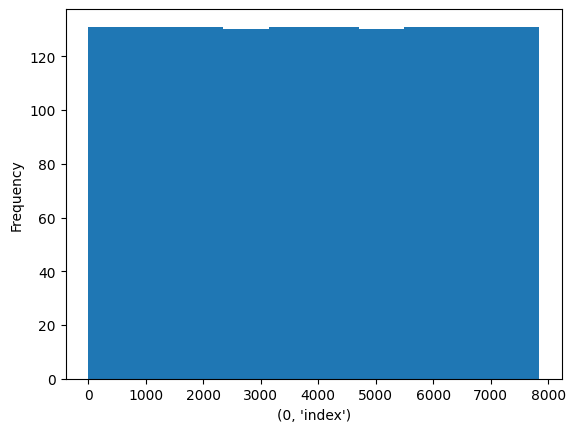

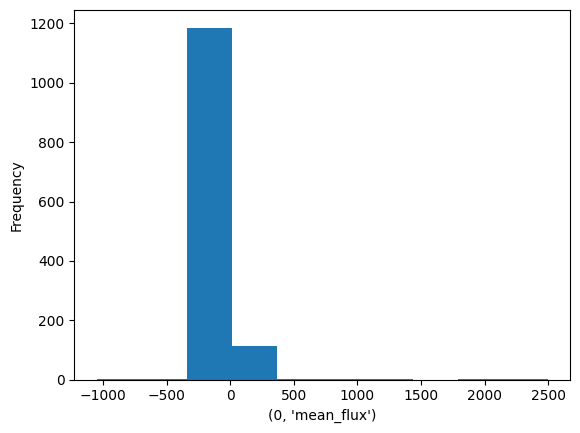

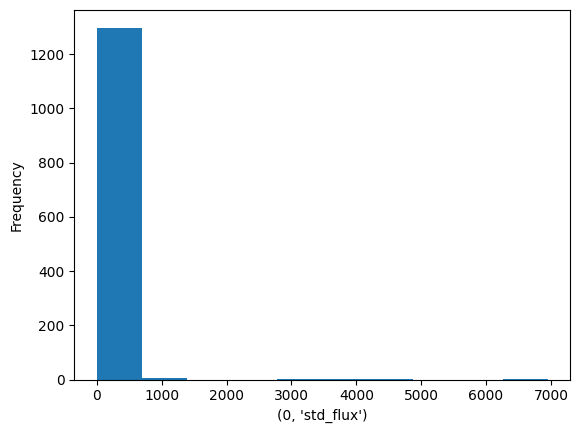

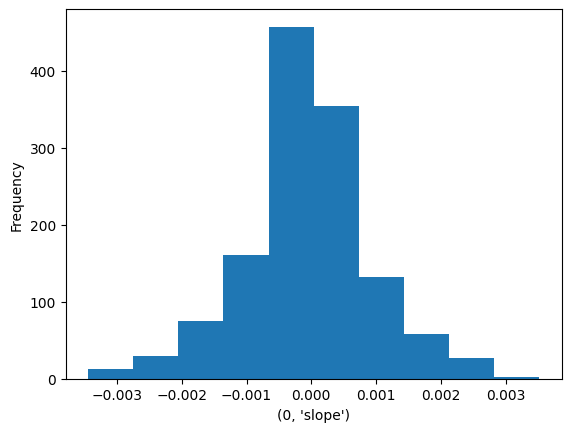

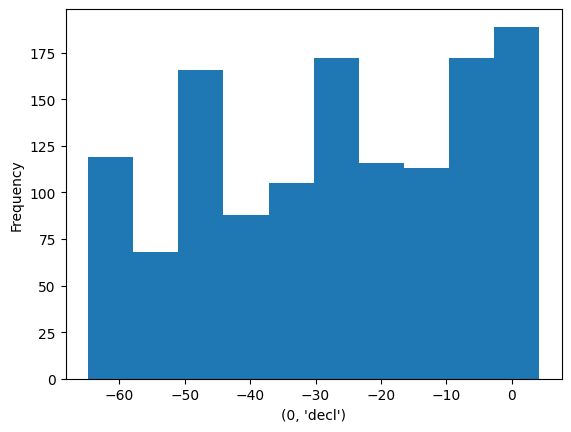

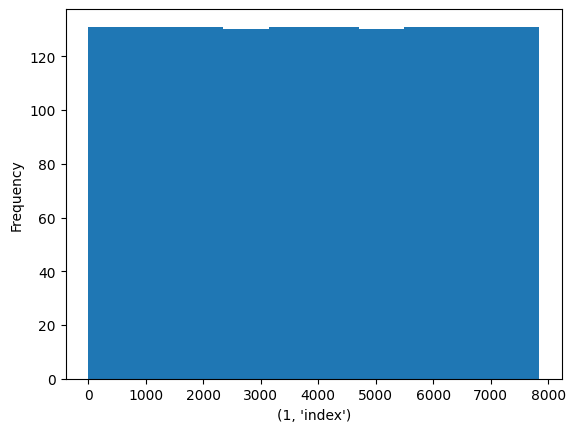

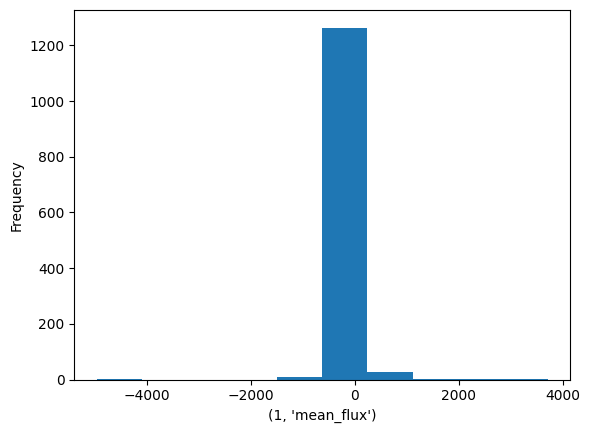

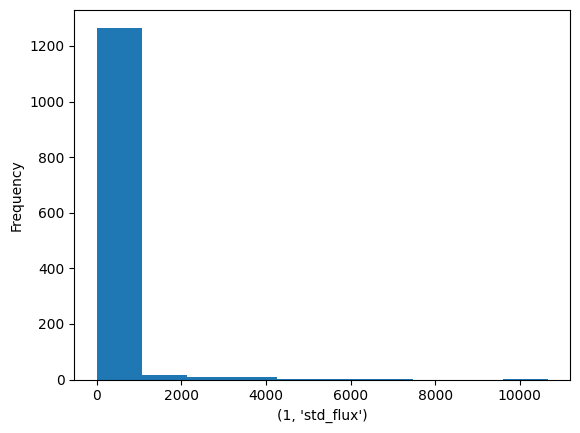

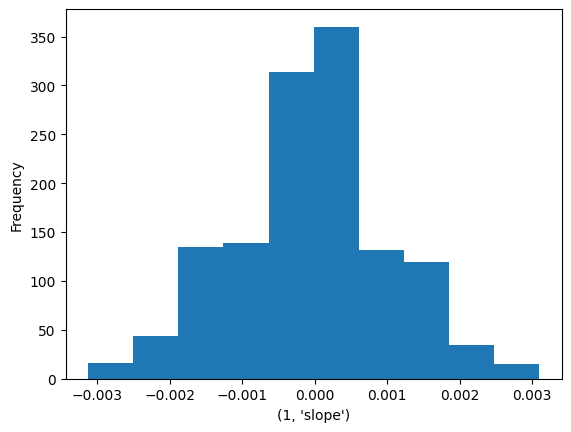

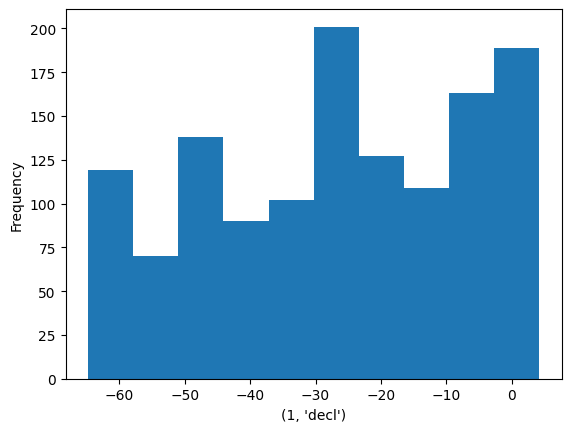

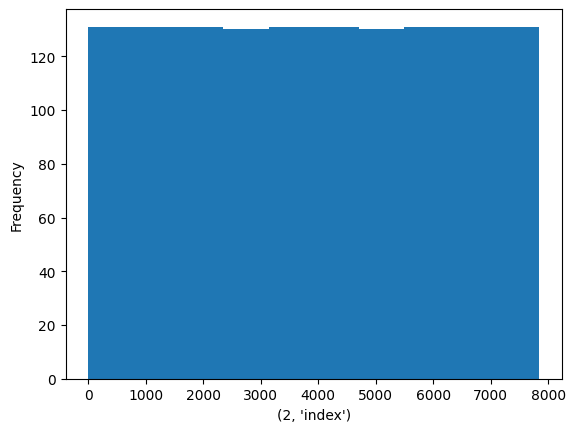

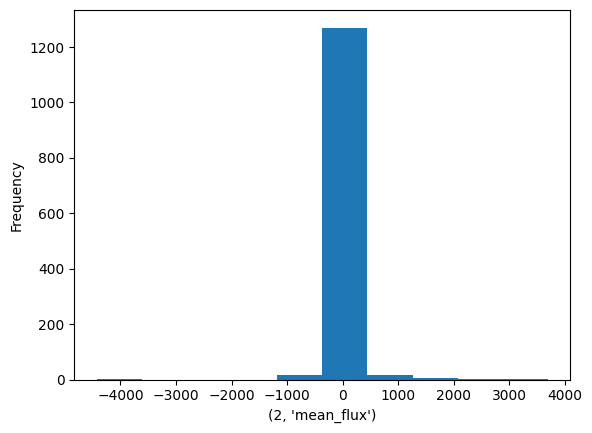

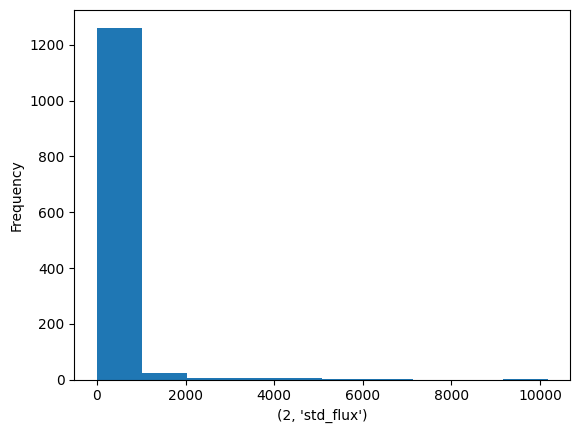

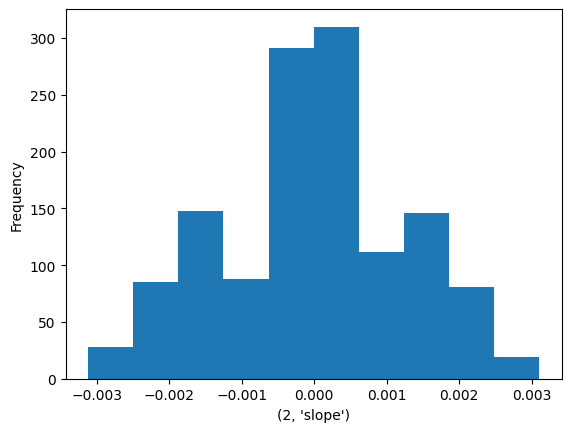

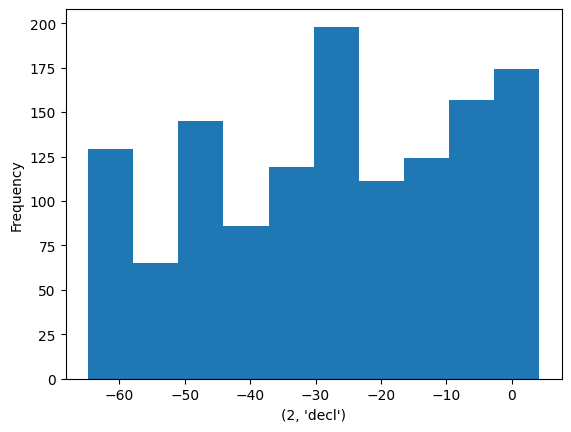

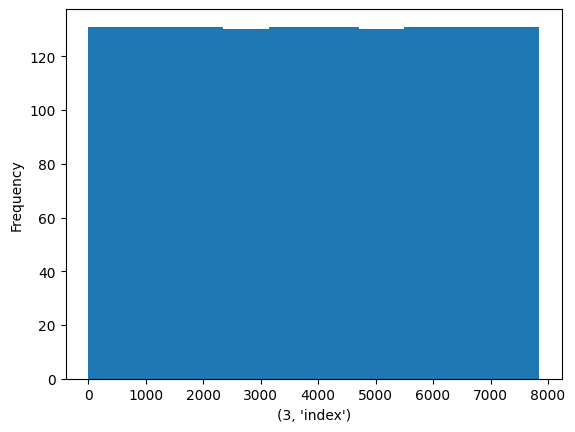

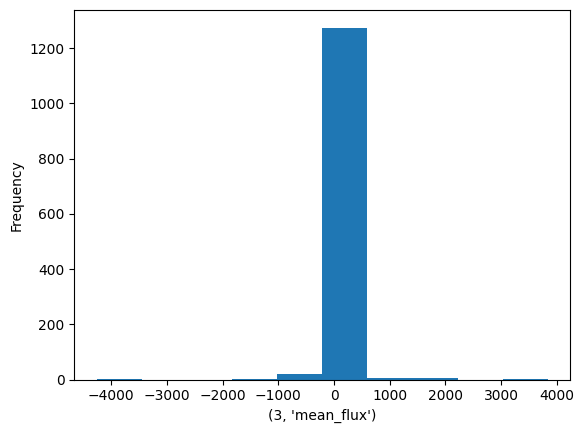

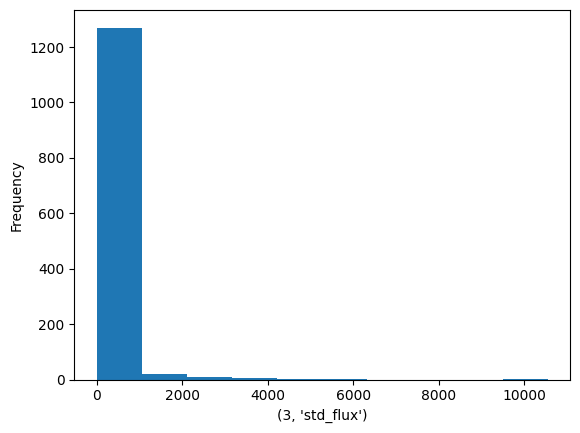

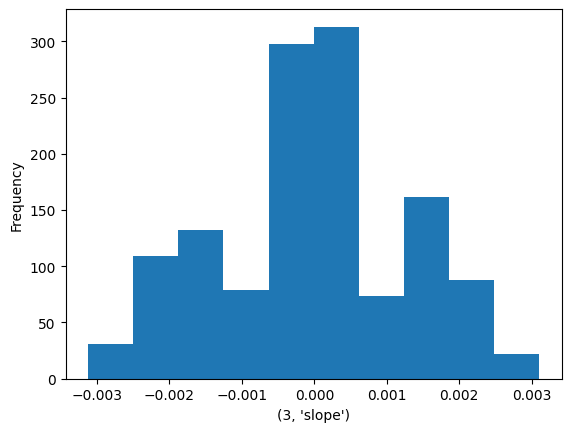

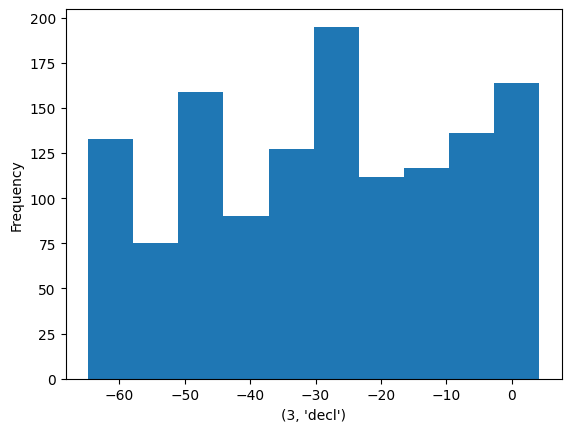

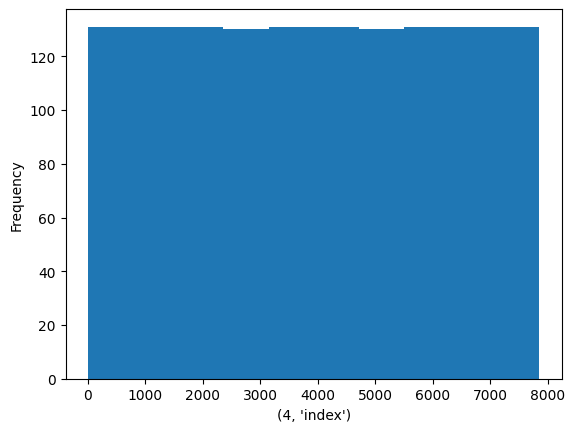

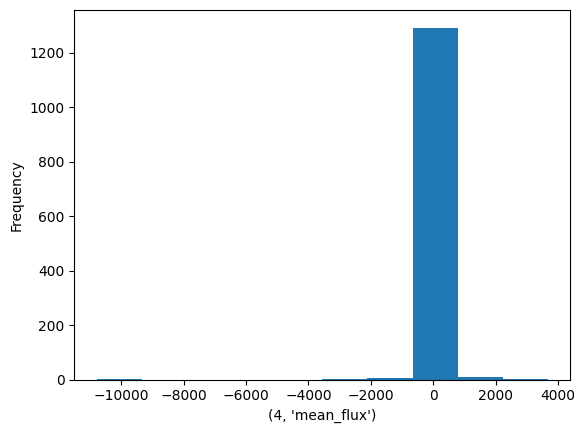

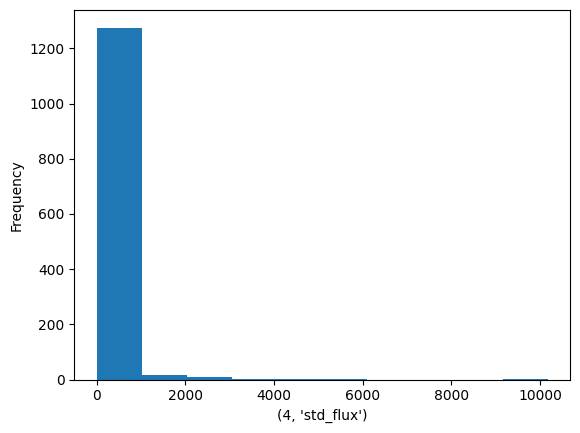

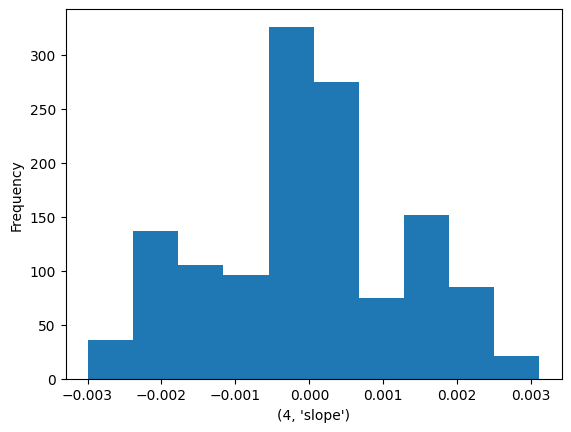

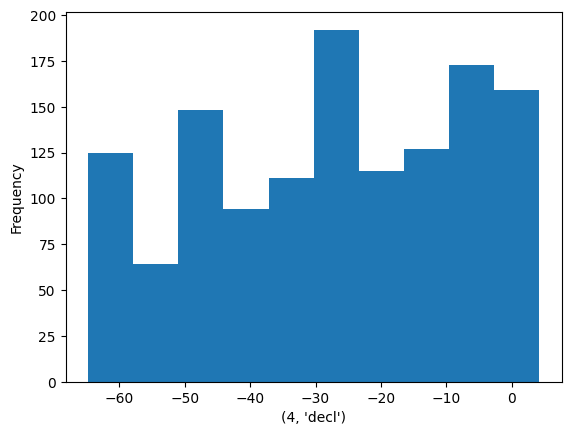

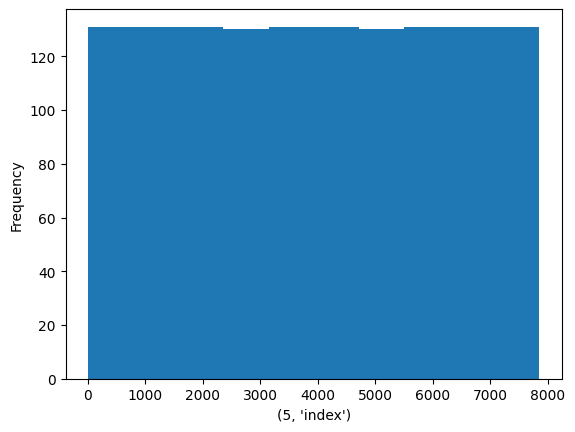

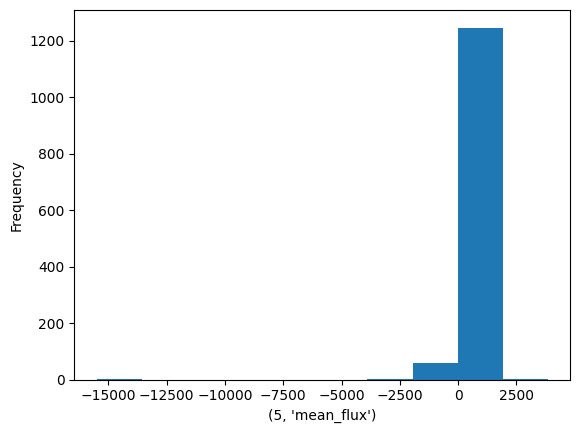

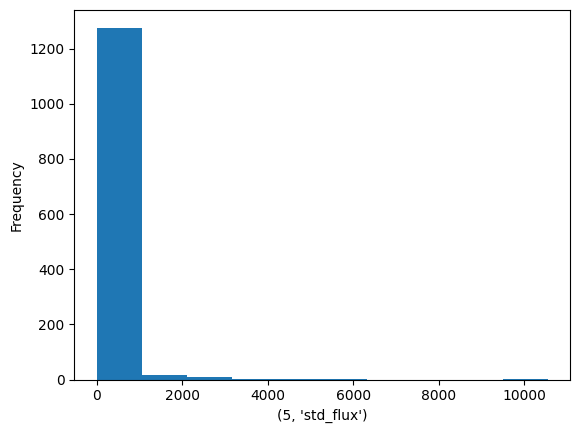

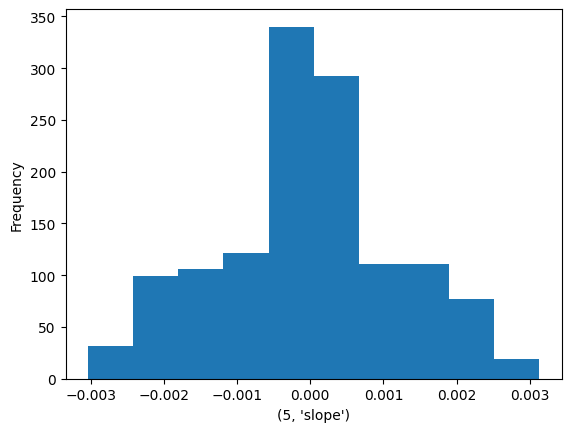

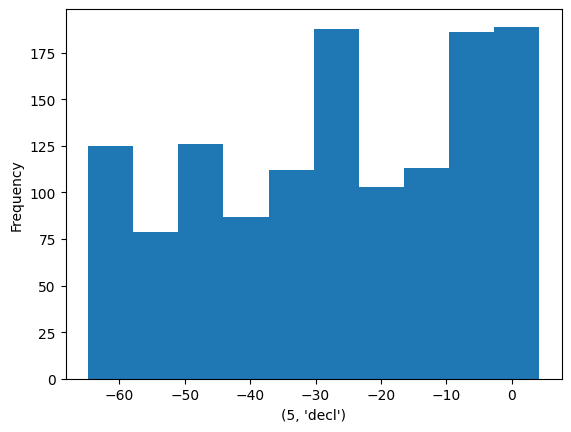

In [88]:
for i in allfeatures.columns:
  pl.figure()
  pl.hist(allfeatures[i])
  pl.xlabel(i)
  pl.ylabel('Frequency')


# TASK III : Gaussian Processes

Take the time series and fit them with GPs.
- use the george package goerge (see class demo https://github.com/fedhere/MLTSA_FBianco/blob/main/CodeExamples/GP_examples.ipynb)

- make sure you use the standardized time series : before you fit the GP to it each time series shoud be made to be mean 0 and standard deviation 1 (note - mean across all time stamps! not across all lightcurves). YOu can just do it by hand as lc /= lc.mean() or you can use `sklearn.preprocessing.StandardScaler`

- make sure you process the uncertainty as well as the data in the standardization! (divide by the same constant the lighcruve fluxes and its uncertaities)

- choose an appropriate kernel (e.g. the composite one we use in class that enables periodicity as well as stockastic variations)

- take a subset of the time series, ~10, making sure that they are of different types: the type is mapped to the metadata `target` variable

- fit the GP kernerl to each time series band by band

- collect the best fit parameters and describe their variance (across the 10 time series) `gp.get_parameter_vector()` - can all the time series be fit with the same kernel parameters? how would you initialize the fit for the whole ensamble?



In [89]:
%pip install george

<ipython-input-90-bc415417fce9>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scaled_df = groups.apply(scale).reset_index(drop=True)


Processing object 50787617.0
Processing object 2110685.0
Processing object 236699.0
Error processing 236699.0, passband 2: array must not contain infs or NaNs
Error processing 236699.0, passband 4: array must not contain infs or NaNs
Error processing 236699.0, passband 5: array must not contain infs or NaNs
Processing object 26842116.0
Processing object 62987535.0
Error processing 62987535.0, passband 1: array must not contain infs or NaNs
Error processing 62987535.0, passband 4: 3-th leading minor of the array is not positive definite
Processing object 8383041.0
Processing object 128113763.0
Error processing 128113763.0, passband 2: 5-th leading minor of the array is not positive definite
Error processing 128113763.0, passband 3: 7-th leading minor of the array is not positive definite
Processing object 90468382.0
Processing object 63647776.0
Error processing 63647776.0, passband 0: 5-th leading minor of the array is not positive definite
Error processing 63647776.0, passband 4: array

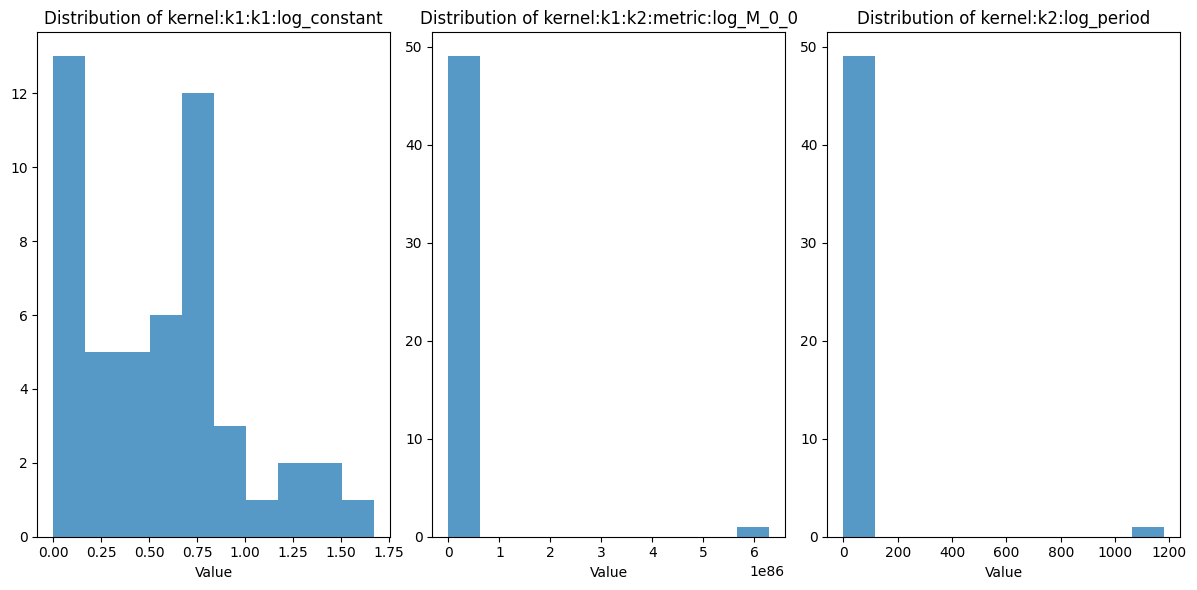

In [90]:



# Load data
lcvs = pd.read_csv("training_set.csv")
metadata = pd.read_csv("training_set_metadata.csv")

def standardize_flux(df):
    """
    Standardizes flux and error values per object_id and passband.
    Returns DataFrame with scaled flux and errors.
    """
    groups = df.groupby(['object_id', 'passband'])

    def scale(group):
        m = group['flux'].mean()
        s = group['flux'].std() + 1e-8  # Avoid division by zero
        group['scaled_flux'] = (group['flux'] - m) / s
        group['scaled_err'] = group['flux_err'] / s
        return group

    scaled_df = groups.apply(scale).reset_index(drop=True)
    return scaled_df

lcvs_standardized = standardize_flux(lcvs)

# Select 10 objects with diverse targets
selected_objects = []
targets_seen = set()
metadata_shuffled = metadata.sample(frac=1, random_state=42)  # Shuffle for diversity

for _, row in metadata_shuffled.iterrows():
    if len(selected_objects) >= 10:
        break
    target = row['target']
    obj_id = row['object_id']

    # Check if object has light curve data and hasn't been seen yet
    if (target not in targets_seen) and \
       not lcvs_standardized[lcvs_standardized['object_id'] == obj_id].empty:
        selected_objects.append(obj_id)
        targets_seen.add(target)

# Fit GPs for each object and passband, collect parameters
results = []

for obj_id in selected_objects:
    print(f"Processing object {obj_id}")

    # Get metadata target for reference (though not used here)
    obj_target = metadata[metadata['object_id'] == obj_id]['target'].values[0]

    for pb in range(6):  # Passbands 0-5
        df_band = lcvs_standardized[
            (lcvs_standardized['object_id'] == obj_id) &
            (lcvs_standardized['passband'] == pb)
        ]

        if len(df_band) < 2:
            continue

        times = df_band['mjd'].values
        y = df_band['scaled_flux'].values
        yerr = df_band['scaled_err'].values

        # Define kernel components with initial guesses
        const_kernel = ConstantKernel(log_constant=np.log(1.0))
        exp_sq = ExpSquaredKernel(metric=0.5)
        cosine_kern = CosineKernel(log_period=np.log(10.0))
        # white_kern = WhiteKernel(log_white_noise=np.log(0.1))

        kernel = const_kernel * exp_sq + cosine_kern
        # kernel = george.GP(
        #   kernel=kernel,
        #   white_noise=np.log(0.1), # Set the log(variance) directly
        #   fit_white_noise=True)

        try:
            gp = george.GP(kernel, mean=0)
            gp.compute(times, yerr=yerr)

            # Negative log-likelihood for optimization
            def nll(params):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

            initial_params = gp.get_parameter_vector()
            result = minimize(nll, initial_params, method='L-BFGS-B')

            if not result.success:
                print(f"Fit failed for object {obj_id}, passband {pb}")
                continue

            best_params = result.x
            param_names = gp.get_parameter_names()

            # Store results with parameter names and other metadata
            entry = {
                'object_id': obj_id,
                'passband': pb,
                'target_type': int(obj_target)
            }

            for name, value in zip(param_names, best_params):
                entry[name] = value

            results.append(entry)
        except Exception as e:
            print(f"Error processing {obj_id}, passband {pb}: {str(e)}")
            continue

# Convert to DataFrame
df_params = pd.DataFrame(results)

if not df_params.empty:
    # Analyze parameters
    param_cols = [col for col in df_params.columns if 'log' in col or 'metric' in col]

    print("\nParameter Statistics:")
    for col in param_cols:
        data = np.exp(df_params[col].values)  # Exponentiate log-parameters
        print(f"{col}: Mean={np.mean(data):.2f}, Std={np.std(data):.2f}")

    # Example visualization of parameter distribution
    plt.figure(figsize=(12,6))
    for i, col in enumerate(param_cols[:3], 1):
        plt.subplot(1,3,i)
        data = df_params[col].apply(lambda x: np.exp(x)).values
        plt.hist(data, bins=10, alpha=0.75)
        plt.title(f"Distribution of {col}")
        plt.xlabel("Value")

    plt.tight_layout()
    plt.show()

else:
    print("No valid fits could be performed.")

# CHALLENGE (Extra Credit): fit the 2D time series:
- create a 2D array for each of the ~10 time series you used earlier: 1 dimension is time the other is wavelength (the bandpass)
- fit a 2D kernel to the time series.
- show the fits with their uncertainties marginalized along one feature at a time: the fit along the time axis for all 6 bands and the fit along the wavelength axis for a subset of the datapoints.
- (try and make a surface plot  that conveys the relevant info effectively, I find it difficult)